# OBJECTIVE :- Compute Word Vectors using TruncatedSVD

In [2]:
# Importing libraries
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from nltk.stem.porter import PorterStemmer

import re

import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

# Loading Data

In [3]:
# using the SQLite Table to read data.
con1 = sqlite3.connect('database.sqlite')

# Eliminating neutral reviews i.e. those reviews with Score = 3
filtered_data = pd.read_sql_query(" SELECT * FROM Reviews WHERE Score != 3 ", con1)

# Give reviews with Score>3 a positive rating, and reviews with a score<3 a negative rating.
def polarity(x):
    if x < 3:
        return 'negative'
    return 'positive'

# Applying polarity function on Score column of filtered_data
filtered_data['Score'] = filtered_data['Score'].map(polarity)

print(filtered_data.shape)
filtered_data.head()

(525814, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,positive,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,negative,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,positive,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,negative,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,positive,1350777600,Great taffy,Great taffy at a great price. There was a wid...


# Data Cleaning: Deduplication

In [4]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
print(final.shape)

#Checking to see how much % of data still remains
((final.shape[0]*1.0)/(filtered_data.shape[0]*1.0)*100)

(364173, 10)


69.25890143662969

In [5]:
# Removing rows where HelpfulnessNumerator is greater than HelpfulnessDenominator
final = final[final.HelpfulnessNumerator <= final.HelpfulnessDenominator]

print(final.shape)
final[30:50]

(364171, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
138683,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,positive,940809600,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...
138676,150493,0006641040,AMX0PJKV4PPNJ,"E. R. Bird ""Ramseelbird""",71,72,positive,1096416000,Read it once. Read it twice. Reading Chicken S...,"These days, when a person says, ""chicken soup""..."
138682,150500,0006641040,A1IJKK6Q1GTEAY,A Customer,2,2,positive,1009324800,It Was a favorite!,This was a favorite book of mine when I was a ...
138681,150499,0006641040,A3E7R866M94L0C,"L. Barker ""simienwolf""",2,2,positive,1065830400,Can't explain why,This book has been a favorite of mine since I ...
476617,515426,141278509X,AB1A5EGHHVA9M,CHelmic,1,1,positive,1332547200,The best drink mix,This product by Archer Farms is the best drink...
22621,24751,2734888454,A1C298ITT645B6,Hugh G. Pritchard,0,0,positive,1195948800,Dog Lover Delites,Our dogs just love them. I saw them in a pet ...
22620,24750,2734888454,A13ISQV0U9GZIC,Sandikaye,1,1,negative,1192060800,made in china,My dogs loves this chicken but its a product f...
284375,308077,2841233731,A3QD68O22M2XHQ,LABRNTH,0,0,positive,1345852800,Great recipe book for my babycook,This book is easy to read and the ingredients ...
157850,171161,7310172001,AFXMWPNS1BLU4,H. Sandler,0,0,positive,1229385600,Excellent treats,I have been feeding my greyhounds these treats...
157849,171160,7310172001,A74C7IARQEM1R,stucker,0,0,positive,1230076800,Sophie's Treats,This is one product that my welsh terrier can ...


OBSERVATION :- Here books with ProductId - 0006641040 and 2841233731 are also there so we have to remove all these rows with these ProductIds from the data

In [6]:
final = final[final['ProductId'] != '2841233731']
final = final[final['ProductId'] != '0006641040']
final.shape

(364136, 10)

# Text Preprocessing: Stemming, stop-word removal and Lemmatization.

In [7]:
#set of stopwords in English
from nltk.corpus import stopwords
stop = set(stopwords.words('english'))
words_to_keep = set(('not'))
stop -= words_to_keep
#initialising the snowball stemmer
sno = nltk.stem.SnowballStemmer('english')

 #function to clean the word of any html-tags
def cleanhtml(sentence):
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext

#function to clean the word of any punctuation or special characters
def cleanpunc(sentence): 
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned

In [8]:
#Code for removing HTML tags , punctuations . Code for removing stopwords . Code for checking if word is not alphanumeric and
# also greater than 2 . Code for stemmimg and also to convert them to lowercase letters 
i=0
str1=' '
final_string=[]
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
s=''
for sent in final['Text'].values:
    filtered_sentence=[]
    #print(sent);
    sent=cleanhtml(sent) # remove HTMl tags
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if(cleaned_words.lower() not in stop):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if (final['Score'].values)[i] == 'positive': 
                        all_positive_words.append(s) #list of all words used to describe positive reviews
                    if(final['Score'].values)[i] == 'negative':
                        all_negative_words.append(s) #list of all words used to describe negative reviews reviews
                else:
                    continue
            else:
                continue 
    
    str1 = b" ".join(filtered_sentence) #final string of cleaned words
    
    
    final_string.append(str1)
    i+=1

In [9]:
#adding a column of CleanedText which displays the data after pre-processing of the review
final['CleanedText']=final_string  
final['CleanedText']=final['CleanedText'].str.decode("utf-8")
#below the processed review can be seen in the CleanedText Column 
print('Shape of final',final.shape)
final.head()

Shape of final (364136, 11)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
476617,515426,141278509X,AB1A5EGHHVA9M,CHelmic,1,1,positive,1332547200,The best drink mix,This product by Archer Farms is the best drink...,product archer farm best drink mix ever mix fl...
22621,24751,2734888454,A1C298ITT645B6,Hugh G. Pritchard,0,0,positive,1195948800,Dog Lover Delites,Our dogs just love them. I saw them in a pet ...,dog love saw pet store tag attach regard made ...
22620,24750,2734888454,A13ISQV0U9GZIC,Sandikaye,1,1,negative,1192060800,made in china,My dogs loves this chicken but its a product f...,dog love chicken product china wont buy anymor...
157850,171161,7310172001,AFXMWPNS1BLU4,H. Sandler,0,0,positive,1229385600,Excellent treats,I have been feeding my greyhounds these treats...,feed greyhound treat year hound littl finicki ...
157849,171160,7310172001,A74C7IARQEM1R,stucker,0,0,positive,1230076800,Sophie's Treats,This is one product that my welsh terrier can ...,one product welsh terrier eat sophi food alerg...


RANDOMLY SAMPLING 25K POINTS OUT OF WHOLE DATASET

In [10]:
##Sorting data according to Time in ascending order for Time Based Splitting
time_sorted_data = final.sort_values('Time', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

# We will collect different 40K rows without repetition from time_sorted_data dataframe
my_final = time_sorted_data.take(np.random.permutation(len(final))[:25000])

sample = my_final['CleanedText'].values

# Defining 'WordVector' Class to compute word vectors using TruncatedSVD

In [12]:
# Definition of class
class WordVector:
    
    
    # Initialising the max_features and sample_data to pass in TFIDF vectorizer
    def __init__(self, max_feat , sample_data):
        self.max_feat = max_feat # No.of top words
        self.sample_data = sample_data # document to vectorize
        # List of all top max_feat words
        self.top_words = []
        self.freq = []
    
    # Picking top max_feat words by using TFIDF vextorizer 
    def topWords(self):
        tf_idf_vect = TfidfVectorizer(max_features=self.max_feat)
        tfidf_vec = tf_idf_vect.fit_transform(self.sample_data)
        print("the type of count vectorizer :",type(tfidf_vec))
        print("the shape of out text TFIDF vectorizer : ",tfidf_vec.get_shape())
        print("the number of unique words :", tfidf_vec.get_shape()[1])
        
        # Top 'n' words
        self.top_words = tf_idf_vect.get_feature_names()
        # tfidf frequencies of top 'n' words
        self.freq = tf_idf_vect.idf_
        
        return tf_idf_vect.get_feature_names()
    
    # Computing the co-occurrence matrix with value of neighbourhood as neighbour_num
    def cooccurrenceMatrix(self, neighbour_num , list_words):
        
        # Storing all words with their indices in the dictionary
        corpus = dict()
        # List of all words in the corpus
        doc = []
        index = 0
        for sent in self.sample_data:
            for word in sent.split():
                doc.append(word)
                corpus.setdefault(word,[])
                corpus[word].append(index)
                index += 1
        
        # Co-occurrence matrix
        matrix = []
        # rows in co-occurrence matrix
        for row in list_words:
            # row in co-occurrence matrix
            temp = []
            # column in co-occurrence matrix 
            for col in list_words :
                if( col != row):
                    # No. of times col word is in neighbourhood of row word
                    count = 0
                    # Value of neighbourhood
                    num = neighbour_num
                    # Indices of row word in the corpus
                    positions = corpus[row]
                    for i in positions:
                        if i<(num-1):
                            # Checking for col word in neighbourhood of row
                            if col in doc[i:i+num]:
                                count +=1
                        elif (i>=(num-1)) and (i<=(len(doc)-num)):
                            # Check col word in neighbour of row
                            if (col in doc[i-(num-1):i+1]) and (col in doc[i:i+num]):
                                count +=2
                            # Check col word in neighbour of row
                            elif (col in doc[i-(num-1):i+1]) or (col in doc[i:i+num]):
                                count +=1
                        else :
                            if (col in doc[i-(num-1):i+1]):
                                count +=1
                            
                                
                    # appending the col count to row of co-occurrence matrix
                    temp.append(count)
                else:
                    # Append 0 in the column if row and col words are equal
                    temp.append(0)
            # appending the row in co-occurrence matrix        
            matrix.append(temp)
        # Return co-occurrence matrix
        return np.array(matrix) 
    
    
    # Function to draw Cumulative_explained_variance VS n_components plot to find optimal number of components for co-occurrence
    def plotCumulativeVariance(self, co_occurrence_matrix):
        #Applying TruncatedSVD
        from sklearn.decomposition import TruncatedSVD
        max_features = co_occurrence_matrix.shape[1]-1
        svd = TruncatedSVD(n_components=max_features)
        svd_data = svd.fit_transform(co_occurrence_matrix)
        percentage_var_explained = svd.explained_variance_ / np.sum(svd.explained_variance_)
        cum_var_explained = np.cumsum(percentage_var_explained)
        # Plot the TrunvatedSVD spectrum
        plt.figure(1, figsize=(6, 4))
        plt.clf()
        plt.plot(cum_var_explained, linewidth=2)
        plt.axis('tight')
        plt.grid()
        plt.xlabel('n_components')
        plt.ylabel('Cumulative_explained_variance')
        plt.title("Cumulative_explained_variance VS n_components")
        plt.show()
        
    # Function to get matrix of word_vectors U'(n*k matrix) using TruncatedSVD . Here 'k' is the optimal number of features
    # Here pass co-occurrence matrix  and optimal no. of components
    def computeVectors(self, co_occurrence_matrix, num_components):
        from sklearn.decomposition import TruncatedSVD
        svd_trunc = TruncatedSVD(n_components=num_components)
        svd_transform = svd_trunc.fit_transform(co_occurrence_matrix)
        # Returns Transformed matrix of Word-Vectors
        return svd_transform
    
    # Applying k-means clustering and obtaining all the clusters
    def getClusters(self, num_clusters, matrix_word_vec):
        from sklearn.cluster import KMeans
        kmeans = KMeans(n_clusters=num_clusters, n_jobs=-1).fit(matrix_word_vec)
        index = [i for i in range(len(self.top_words))]
        d = dict()
        for (key, value) in zip(kmeans.labels_, index):
            d.setdefault(key,[])
            d[key].append(value)
        # List of all clusters
        clusters = []
        labels = sorted(list(set(kmeans.labels_)))
        for i in labels:
            temp = []
            for idx in sorted(d[i]):
                temp.append(self.top_words[idx])
            clusters.append(temp)
            
        # Return the list of clusters
        return clusters
    
    # Function to generate word cloud
    def generateWordCloud(self, list_of_words):
        from wordcloud import WordCloud, STOPWORDS
        stopwords = set(STOPWORDS)
        
        # Dictionary consisting of words as keys and their frequencies as values
        word_dict = {word : self.freq[self.top_words.index(word)] for word in list_of_words}
        
        # Initialising and generating wordcloud
        wc = WordCloud(background_color='white', stopwords=stopwords, max_words=100, max_font_size=40, random_state=42)
        wc.generate_from_frequencies(word_dict)
        
        # Show wordcloud
        plt.figure(figsize = (12, 8), facecolor = None)
        plt.imshow(wc, interpolation="bilinear")
        plt.axis("off")
        plt.tight_layout(pad = 0)
        plt.show()
                   

#  (a). Using WordVector class for computing Word Vectors for top 2K words :

In [15]:
# Creating the object of WordVector class for top 2K words and using 'sample' dataset
wv = WordVector(2000,sample)

# Picking top 2K words
words_top = wv.topWords()

the type of count vectorizer : <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer :  (25000, 2000)
the number of unique words : 2000


Shape of co-occurrence matrix :  (2000, 2000)




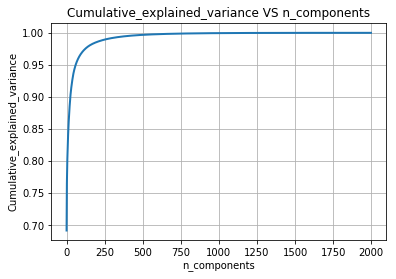

In [16]:
# Computing the co-occurrence matrix for 'words_top' with value of neighbourhood = 5
co_occ_matrix = wv.cooccurrenceMatrix(5, words_top)
print("Shape of co-occurrence matrix : ",co_occ_matrix.shape )
print('\n')

# drawing Cumulative_explained_variance VS n_components plot to find optimal number of components for co-occurrence matrix
wv.plotCumulativeVariance(co_occ_matrix)

OBSERVATION :-  From above we can observe that only 250 components can explain almost 99% of variance . So, it will be good to use only 250 components instead of total 2000 components .

In [17]:
# Computing word vectors with 250 components
word_vec_matrix = wv.computeVectors(co_occ_matrix, 250)
print("Shape of word-vector : ",word_vec_matrix.shape)

# Applying k-means with no_of_clusters = 50 on 'word_vec_matrix' and get all clusters
word_cluster = wv.getClusters(50, word_vec_matrix)

Shape of word-vector :  (2000, 250)


# Seeing Words In The Clusters :

In [24]:
print("Words in Cluster- 1 :\n",word_cluster[0])

Words in Cluster- 1 :
 ['bean', 'bitter', 'black', 'blend', 'brew', 'dark', 'green', 'ice', 'morn', 'rich', 'roast', 'smooth', 'strong', 'vanilla']


SUMMARY :- By observing above cluster we can conclude that words in cluster are related to flavours and types of coffee .

In [38]:
print("Words in Cluster- 49 :\n",word_cluster[48][27:37])

Words in Cluster- 49 :
 ['beer', 'benefit', 'berri', 'beverag', 'biscuit', 'bland', 'blue', 'blueberri', 'boil', 'bone']


SUMMARY :- By observing above cluster we can conclude that words in cluster are related to eatables .

# Word Clouds :

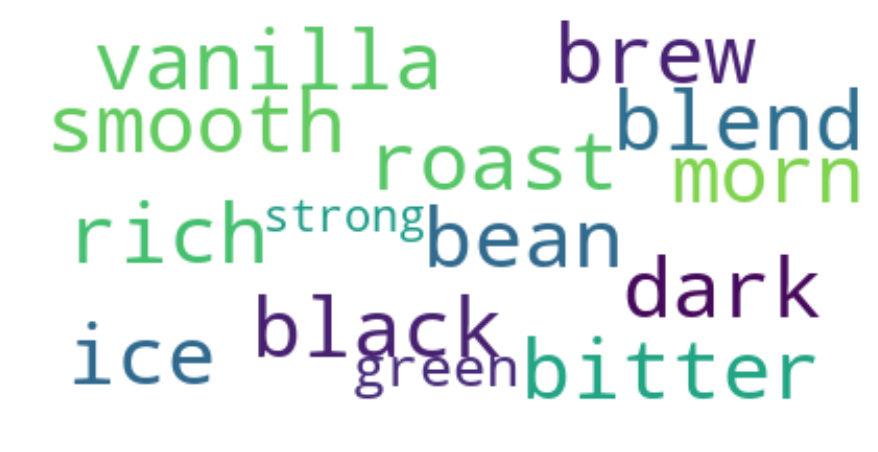

In [37]:
# Word Cloud for cluster-1
wv.generateWordCloud(word_cluster[0])

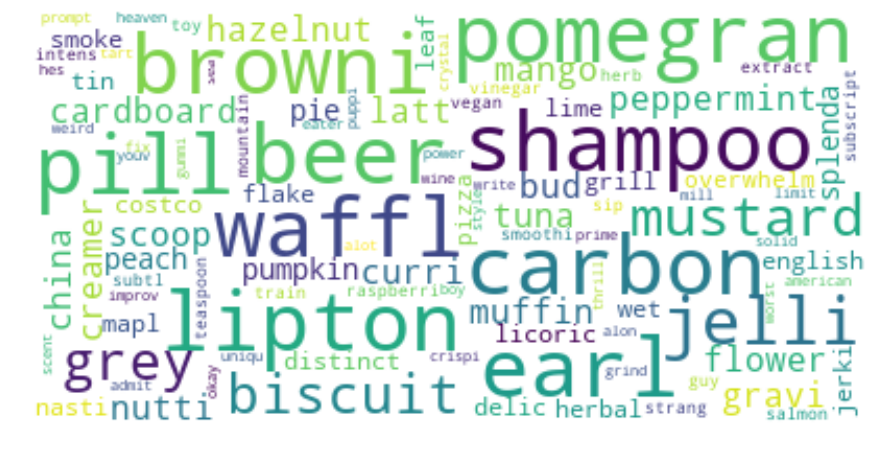

In [39]:
# Word Cloud for cluster -49
wv.generateWordCloud(word_cluster[48])

# (b). Using WordVector class for computing Word Vectors of top 5K words 

In [40]:
# Creating the object of WordVector class for top 5000 words and using 'sample' dataset
wv1 = WordVector(5000,sample)

# Picking top 5000 words
words_top_5000 = wv1.topWords()

the type of count vectorizer : <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer :  (25000, 5000)
the number of unique words : 5000


Shape of co-occurrence matrix :  (5000, 5000)




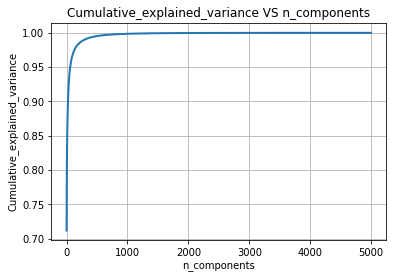

In [41]:
# Computing the co-occurrence matrix for 'words_top_5000' with value of neighbourhood = 5
co_occ_matrix = wv1.cooccurrenceMatrix(5, words_top_5000)
print("Shape of co-occurrence matrix : ",co_occ_matrix.shape )
print('\n')

# drawing Cumulative_explained_variance VS n_components plot to find optimal number of components for co-occurrence matrix
wv1.plotCumulativeVariance(co_occ_matrix)

OBSERVATION :- From above we can observe that only 500 components can explain almost 99% of variance . So, it will be good to use only 500 components instead of total 5000 components .

In [42]:
# Computing word vectors with 500 components
word_vec_matrix = wv1.computeVectors(co_occ_matrix, 500)
print("Shape of word-vector : ",word_vec_matrix.shape)

# Applying k-means with no_of_clusters = 50 on 'word_vec_matrix' and get all clusters
word_cluster = wv1.getClusters(50, word_vec_matrix)

Shape of word-vector :  (5000, 500)


# Seeing Words In The Clusters :

In [45]:
print("Words in Cluster- 3 :\n",word_cluster[2])

Words in Cluster- 3 :
 ['add', 'bit', 'delici', 'differ', 'enjoy', 'favorit', 'fresh', 'hot', 'lot', 'milk', 'nice', 'perfect', 'still', 'strong', 'without', 'wonder']


SUMMARY :- By observing above cluster we can conclude that words in cluster are related to qualities of different drinkables .

In [49]:
print("Words in Cluster- 39 :\n",word_cluster[38])

Words in Cluster- 39 :
 ['actual', 'ad', 'anyth', 'bad', 'bar', 'calori', 'candi', 'cereal', 'chip', 'coconut', 'cook', 'cooki', 'definit', 'didnt', 'doesnt', 'dri', 'enough', 'excel', 'expect', 'far', 'feel', 'fruit', 'howev', 'ingredi', 'kid', 'less', 'natur', 'oil', 'organ', 'peopl', 'pretti', 'put', 'quit', 'real', 'regular', 'rice', 'salt', 'sauc', 'seem', 'smell', 'someth', 'sure', 'tasti', 'textur', 'though', 'thought']


SUMMARY :- By observing above cluster we can conclude that words in cluster are related to eatables and their qualities and quantities .

# Word Clouds :

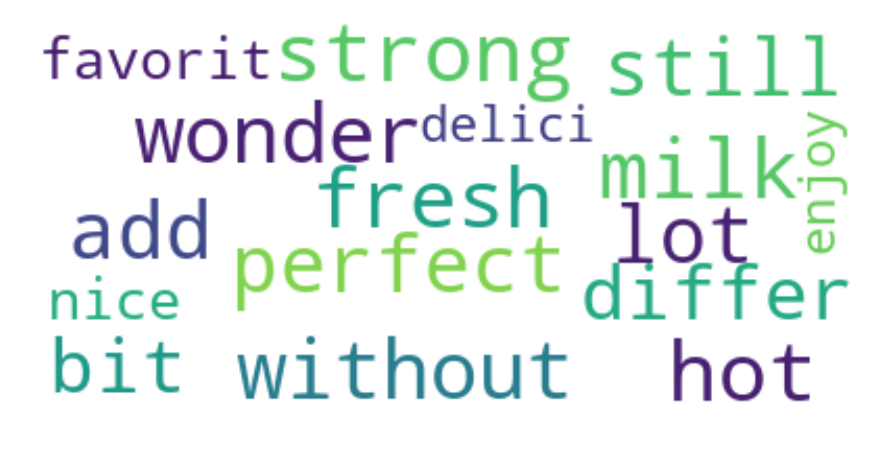

In [50]:
# Word Cloud for cluster-3
wv1.generateWordCloud(word_cluster[2])

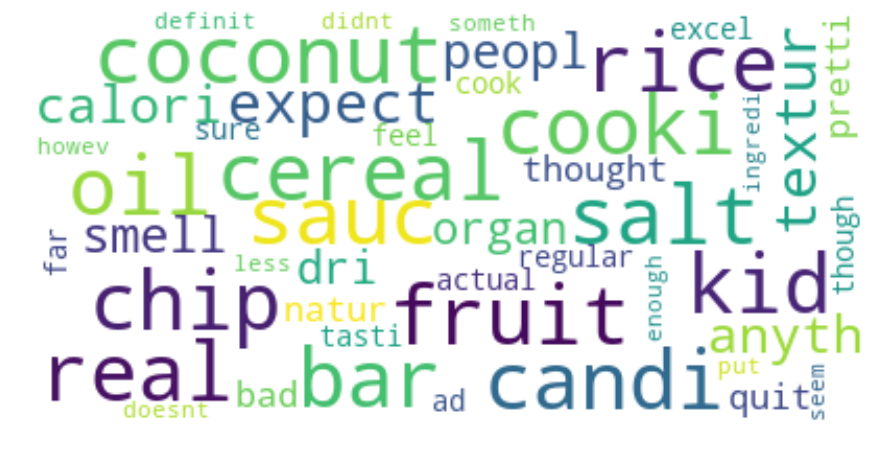

In [51]:
# Word Cloud for cluster-39
wv1.generateWordCloud(word_cluster[38])

# (c). Using WordVector class for computing Word Vectors of top 10K words

In [52]:
# Creating the object of WordVector class for top 10K words and using 'sample' dataset
wv2 = WordVector(10000,sample)

# Picking top 10K words
words_top_10k = wv2.topWords()

the type of count vectorizer : <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer :  (25000, 10000)
the number of unique words : 10000


Shape of co-occurrence matrix :  (10000, 10000)




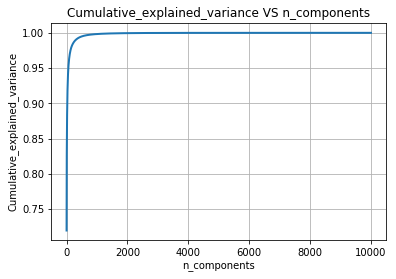

In [53]:
# Computing the co-occurrence matrix for 'words_top_10k' with value of neighbourhood = 5
co_occ_matrix = wv2.cooccurrenceMatrix(5, words_top_10k)
print("Shape of co-occurrence matrix : ",co_occ_matrix.shape )
print('\n')

# drawing Cumulative_explained_variance VS n_components plot to find optimal number of components for co-occurrence matrix
wv2.plotCumulativeVariance(co_occ_matrix)

OBSERVATION :- From above we can observe that only 700 components can explain almost 99% of variance . So, it will be good to use only 700 components instead of total 10000 components .

In [54]:
# Computing word vectors with 700 components
word_vec_matrix = wv2.computeVectors(co_occ_matrix, 700)
print("Shape of word-vector : ",word_vec_matrix.shape)

# Applying k-means with no_of_clusters = 50 on 'word_vec_matrix' and get all clusters
word_cluster = wv2.getClusters(50, word_vec_matrix)

Shape of word-vector :  (10000, 700)


# Seeing Words In The Clusters :

In [58]:
print("Words in Cluster- 10 :\n",word_cluster[9][4:14])

Words in Cluster- 10 :
 ['bad', 'bar', 'butter', 'calori', 'candi', 'cereal', 'chip', 'coconut', 'contain', 'cooki']


SUMMARY :- By observing above cluster we can conclude that words in cluster are related to eatables .

In [62]:
print("Words in Cluster- 15 :\n",word_cluster[14])

Words in Cluster- 15 :
 ['buy', 'get', 'order']


SUMMARY :- By observing above cluster we can conclude that words in cluster are related to online shopping actions .

In [63]:
print("Words in Cluster- 40 :\n",word_cluster[39])

Words in Cluster- 40 :
 ['bag', 'box', 'packag']


SUMMARY :- By observing above cluster we can conclude that words in cluster are related to containers semantically .

In [64]:
print("Words in Cluster- 50 :\n",word_cluster[49])

Words in Cluster- 50 :
 ['anoth', 'arriv', 'back', 'big', 'bottl', 'came', 'case', 'compani', 'definit', 'disappoint', 'excel', 'expens', 'famili', 'friend', 'go', 'got', 'happi', 'hard', 'item', 'last', 'less', 'long', 'month', 'new', 'old', 'open', 'problem', 'qualiti', 'quick', 'reason', 'receiv', 'save', 'see', 'sever', 'ship', 'star', 'start', 'sure', 'thank', 'thought', 'usual', 'whole', 'worth']


SUMMARY :- By observing above cluster we can conclude that words in cluster have some verbs and adjectives and are semantically related to each other .

# Word Clouds :

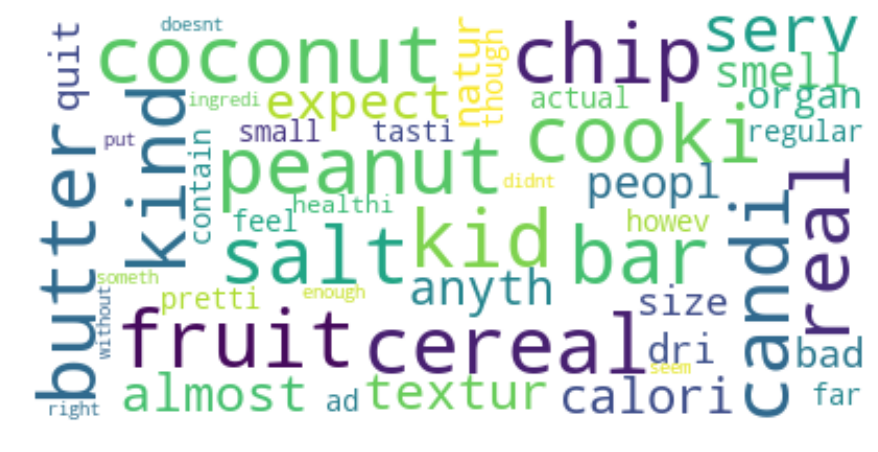

In [65]:
# Word Cloud for cluster-10
wv2.generateWordCloud(word_cluster[9])

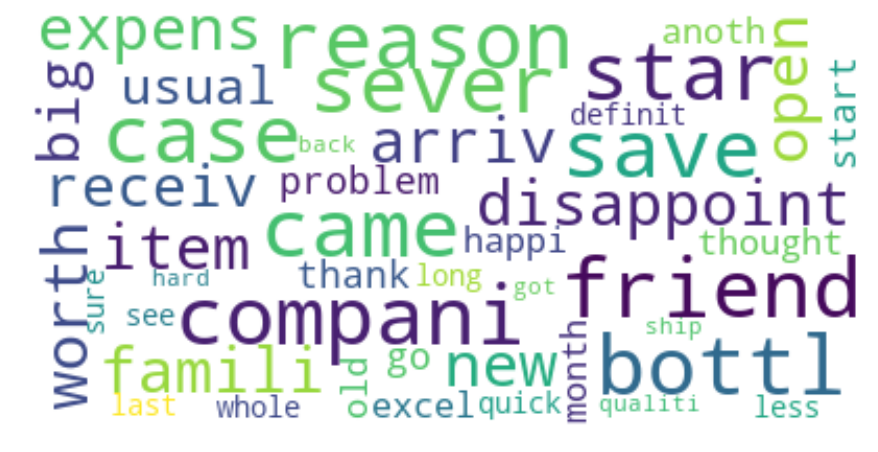

In [66]:
# Word Cloud for cluster-50
wv2.generateWordCloud(word_cluster[49])

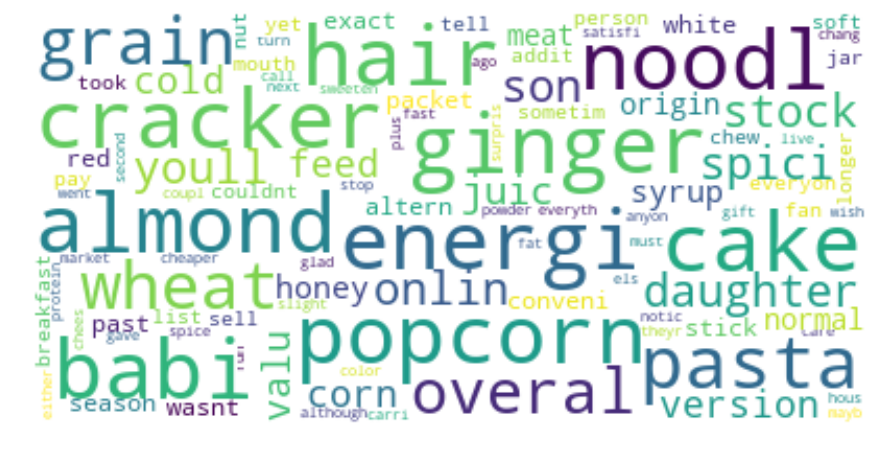

In [72]:
# Word Cloud for cluster-18
wv2.generateWordCloud(word_cluster[17])

# CONCLUSION 

# Procedure Followed :

STEP 1 :- Text Preprocessing

STEP 2 :- Taking all text data and ignoring class variable .

STEP 3:- Definig WordVector class for computing word vectors using TruncatedSVD

STEP 4:- Finding top 'n' words using TFIDF vectorizer 

STEP 5:- Computing co-occurrence matrix using these top 'n' words

STEP 6:- Finding right number of components using cumulative_explained_variance VS n_components plot .

STEP 7 :- Applying TruncatedSVD on this co-occurrence matrix with right number of components in order to find matrix of word-vectors .

STEP 8:- Apply k-means clustering on this matrix of word-vectors and manually seeing the words in the clusters to check whether they are semantically related or not .

STEP 9:- Also creating WordClouds for few clusters for better presentation

Repeat from STEP 4 to STEP 9 using value of n = 2K , 5K and 10K 